In [53]:
# Επεξεργασία και την ανάλυση γραφημάτων
import networkx as nx

import matplotlib.pyplot as plt

import pandas as pd

# Γενικές βιβλιοθήκες
import random

from sklearn import metrics
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_recall_curve,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [54]:
# Ορισμός σταθερού seed
import numpy as np

np.random.seed(42)
random.seed(42)


In [55]:
# Διαβάζουμε τον γράφο από το csv αρχείο 

G = nx.read_edgelist('soc-dolphins.csv', create_using=nx.Graph(), nodetype=int)


# G = nx.read_edgelist('UsAir.csv', delimiter=',', create_using=nx.Graph(), nodetype=int)


In [ ]:
# Σχεδίαση του γράφου

nx.draw(G, with_labels=True)
plt.show()


In [57]:
# Εξαγωγή χαρακτηριστικών από το γράφο

def graph_stats(G):
    degrees = [degree for node, degree in G.degree()]
    node_count = len(G.nodes())
    edge_count = len(G.edges())
    degree_avg = np.mean(degrees) if degrees else 0
    
    if node_count > 1:
        density = 2 * edge_count / (node_count * (node_count - 1))
    else:
        density = 0
    
    return node_count, edge_count, degree_avg, degrees, density

initial_node_count, initial_edge_count, average_degree, degrees, density = graph_stats(G)

print("Number of nodes: ", initial_node_count)
print("Number of edges: ", initial_edge_count)
print("Graph density: ", density)
print("Average degree: ", average_degree)


Number of nodes:  62
Number of edges:  159
Graph density:  0.08408249603384453
Average degree:  5.129032258064516


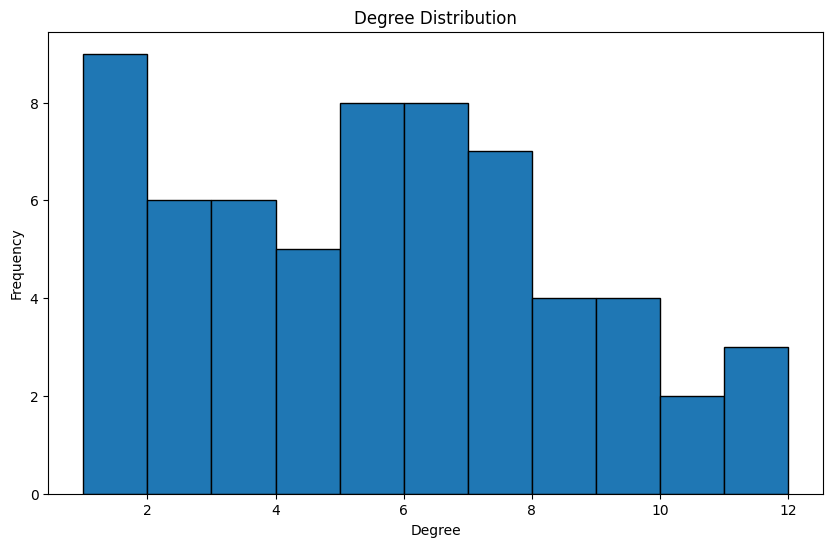

In [58]:
# Απεικόνιση βαθμολογικής κατανομής - Ιστογράμματος

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1, 1), edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


In [ ]:

def extract_CCNPA(G, edge, average_degree, alpha=0.5, beta=0.5):
    u, v = edge
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    common_neighbors = len(neighbors_u & neighbors_v)

    # Preferential Attachment
    preferential_attachment = len(neighbors_u) * len(neighbors_v)

    # Normalized Common Neighbors
    normalized_common_neighbors = common_neighbors / preferential_attachment if preferential_attachment != 0 else 0

    # Node degrees
    degree_u = G.degree[u]
    degree_v = G.degree[v]

    # Normalized Degree for both nodes
    normalized_degree_u = degree_u / average_degree
    normalized_degree_v = degree_v / average_degree
    average_normalized_degree = (normalized_degree_u + normalized_degree_v) / 2

    # Combined Metric
    combined_metric = alpha * normalized_common_neighbors + beta * average_normalized_degree

    return {
        "common_neighbors": common_neighbors,
        "preferential_attachment": preferential_attachment,
        "degree_u": degree_u,
        "degree_v": degree_v,
        "average_degree": average_degree,
        "normalized_common_neighbors": normalized_common_neighbors,
        "average_normalized_degree": average_normalized_degree,
        "combined_metric": combined_metric
    }
    

In [60]:
def extract_CKNCN(G, edge, density, alpha=0.4, beta=0.6):
    u, v = edge

    # Katz centrality based similarity
    katz = nx.katz_centrality(G, alpha=0.005)
    katz_similarity = katz[u] * katz[v]

    # Leicht-Holme-Newman Index
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    lhn_index = len(neighbors_u & neighbors_v) / (len(neighbors_u) * len(neighbors_v)) if len(neighbors_u) * len(neighbors_v) != 0 else 0

    # Adjust influence based on density
    adjusted_katz = katz_similarity * (1 - density)
    adjusted_lhn = lhn_index * density

    # Συνδυασμός των προσαρμοσμένων χαρακτηριστικών
    combined_score = alpha * adjusted_katz + beta * adjusted_lhn

    return combined_score


In [61]:
# Δημιουργία θετικών και αρνητικών δειγμάτων

positive_edges = list(G.edges())  # Θετικά δείγματα
negative_edges = list(nx.non_edges(G))  # Αρνητικά δείγματα
negative_edges = random.sample(negative_edges, len(positive_edges))  # Εξισορρόπηση του αριθμού των δειγμάτων



In [62]:
# Δημιουργία δεδομένων εκπαίδευσης και δοκιμής

data = positive_edges + negative_edges
labels = [1] * len(positive_edges) + [0] * len(negative_edges)
average_degree = np.mean([degree for _, degree in G.degree()])



In [63]:
# Διαχωρισμός σε σετ εκπαίδευσης και δοκιμής

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)


In [64]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Grid Search για Beta και Alpha
alphas = np.linspace(0.1, 0.9, 9)
best_auc = 0
best_alpha = 0
best_beta = 0
results = []

for alpha in alphas:
    beta = 1 - alpha

    # Εξαγωγή χαρακτηριστικών
    X_train_features = [extract_CKNCN(G, edge, density, alpha, beta) for edge in X_train]
    X_test_features = [extract_CKNCN(G, edge, density, alpha, beta) for edge in X_test]

    # Δημιουργία DataFrames
    X_train_df = pd.DataFrame(X_train_features)
    X_test_df = pd.DataFrame(X_test_features)

    # Εκπαίδευση Random Forest
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    model.fit(X_train_df, y_train)

    # Υπολογισμός AUC
    probabilities = model.predict_proba(X_test_df)[:, 1]
    auc = roc_auc_score(y_test, probabilities)
    results.append({'alpha': alpha, 'beta': beta, 'auc': auc})

    if auc > best_auc:
        best_auc = auc
        best_alpha = alpha
        best_beta = beta

print(f"Best Alpha: {best_alpha}, Best Beta: {best_beta}, Best AUC: {best_auc:.4f}")


Best Alpha: 0.8, Best Beta: 0.19999999999999996, Best AUC: 0.8030


In [ ]:
import xgboost as xgb

for alpha in alphas:
    for beta in betas:
        if alpha + beta == 1:
            # Εξαγωγή χαρακτηριστικών για τα δεδομένα εκπαίδευσης με τις τρέχουσες τιμές alpha και beta
            X_train_features = [extract_features(G, edge, average_degree, alpha, beta) for edge in X_train] 
            X_test_features = [extract_features(G, edge, average_degree, alpha, beta) for edge in X_test]

            # Μετατροπή σε DataFrame
            X_train_df = pd.DataFrame(X_train_features)
            X_test_df = pd.DataFrame(X_test_features)

            # Δημιουργία DMatrix για XGBoost
            dtrain = xgb.DMatrix(X_train_df, label=y_train)
            dtest = xgb.DMatrix(X_test_df, label=y_test)

            # Παράμετροι για εκπαίδευση στη GPU
            params = {
                'objective': 'binary:logistic',
                'tree_method': 'gpu_hist',  # Χρήση της GPU
                'eval_metric': 'auc',
                'learning_rate': 0.1,  # Ρυθμός μάθησης
                'max_depth': 6,  
                'min_child_weight': 1,  
                'subsample': 0.8,  
                'colsample_bytree': 0.8, 
                'n_estimators': 100 
            }

            # Εκπαίδευση του μοντέλου
            model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')])

            # Προβλέψεις
            probabilities = model.predict(dtest)
            auc = roc_auc_score(y_test, probabilities)

            if auc > best_auc:
                best_auc = auc
                best_alpha = alpha
                best_beta = beta

In [ ]:
# Εκπαίδευση του τελικού μοντέλου με τις βέλτιστες τιμές alpha και beta

X_train_features = [extract_CCNPA(G, edge, average_degree, best_alpha, best_beta) for edge in X_train]
X_test_features = [extract_CCNPA(G, edge, average_degree, best_alpha, best_beta) for edge in X_test]


In [ ]:
# Εκπαίδευση του τελικού μοντέλου με τις βέλτιστες τιμές alpha και beta

X_train_features = [extract_CKNCN(G, edge, density, best_alpha, best_beta) for edge in X_train]  
X_test_features = [extract_CKNCN(G, edge, best_alpha, best_beta) for edge in X_test]

X_train_df = pd.DataFrame(X_train_features)
X_test_df = pd.DataFrame(X_test_features)



In [ ]:
# Εκπαίδευση του Logistic Regression Classifier

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_df, y_train)


In [68]:
# Εκπαίδευση του Random Forest Classifier

final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_df, y_train)


RandomForestClassifier(random_state=42)

In [69]:
# Προβλέψεις και αξιολόγηση
final_probabilities = final_model.predict_proba(X_test_df)[:, 1]
roc_auc = roc_auc_score(y_test, final_probabilities)
print(f"Final AUC: {roc_auc:.4f}")
precision, recall, thresholds = precision_recall_curve(y_test, final_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold: {best_threshold:.4f}")


Final AUC: 0.7700
Best Threshold: 0.0500


In [70]:
# Υπολογισμός συνολικού αριθμού θετικών και αρνητικών προβλέψεων
total_predicted_positive = sum(final_probabilities)  
total_predicted_negative = len(final_probabilities) - total_predicted_positive

print('Ο συνολικός αριθμός των προβλεπόμενων συνδέσεων: ',len(final_probabilities))
print(f"Συνολικός αριθμός προβλεπόμενων θετικών συνδέσεων: {total_predicted_positive}")
print(f"Συνολικός αριθμός προβλεπόμενων αρνητικών συνδέσεων: {total_predicted_negative}")


total_actual_positive = sum(y_test)
total_actual_negative = len(y_test) - total_actual_positive

print(f"Συνολικός αριθμός πραγματικών θετικών συνδέσεων: {total_actual_positive}")
print(f"Συνολικός αριθμός πραγματικών αρνητικών συνδέσεων: {total_actual_negative}")


Ο συνολικός αριθμός των προβλεπόμενων συνδέσεων:  96
Συνολικός αριθμός προβλεπόμενων θετικών συνδέσεων: 3.9899999999999958
Συνολικός αριθμός προβλεπόμενων αρνητικών συνδέσεων: 92.01
Συνολικός αριθμός πραγματικών θετικών συνδέσεων: 50
Συνολικός αριθμός πραγματικών αρνητικών συνδέσεων: 46


In [71]:
# # Support Vector Machine (SVM) Classifier

# from sklearn.svm import SVC

# # Εκπαίδευση του SVM
# svm_model = SVC(probability=True, random_state=42)
# svm_model.fit(X_train, y_train)

# # Προβλέψεις πιθανοτήτων για το σύνολο δοκιμής
# probabilities = svm_model.predict_proba(X_test)[:, 1]


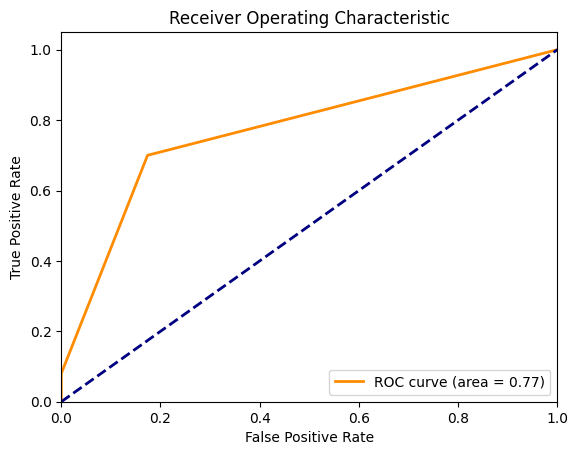

In [72]:
# Απεικόνιση της ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, final_probabilities)
roc_auc = auc(fpr, tpr)  # Υπολογισμός του AUC

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


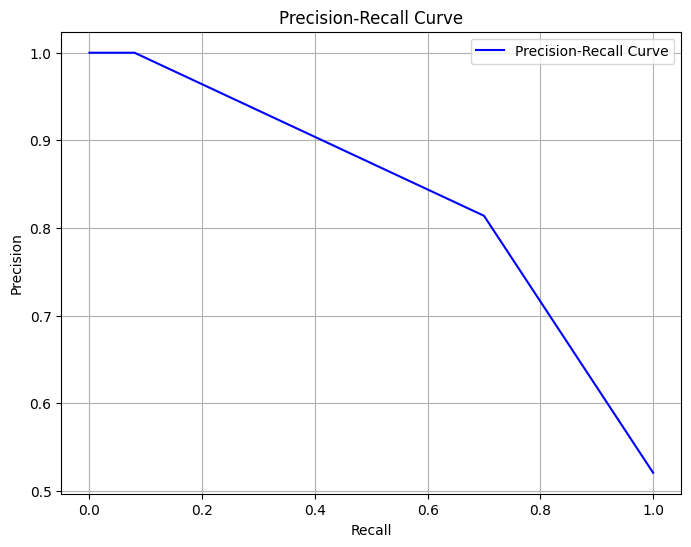

In [73]:
# Απεικόνιση της Precision-Recall Curve

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
